In [121]:
import warnings
import seaborn as sns
import matplotlib.pylab as plt
import PIL
import pandas as pd
import os
from PIL import Image

import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception, VGG16, ResNet50, InceptionV3
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers, models, optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator


import numpy as np # linear algebra

from numpy.random import seed

In [122]:
K.clear_session()

In [123]:
SEED = 2
seed(SEED)
tf.set_random_seed(SEED)

In [124]:
DATA_PATH = '../input'
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')
TRAIN_CROP_PATH = os.path.join(DATA_PATH, 'train_crop_299')
TEST_CROP_PATH = os.path.join(DATA_PATH, 'test_crop_299')

df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))
image_size=299

In [308]:
#https://github.com/yu4u/cutout-random-erasing
def get_random_eraser(p=0.9, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=1, pixel_level=True):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [310]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    fill_mode='nearest',
    preprocessing_function=get_random_eraser(v_l=0, v_h=1)
    )

valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [311]:
def get_generator(train_df, val_df, train_dir, valid_dir, test_df, test_dir, image_size, batch_size,valid_batch_size,
                 scale='rgb', target='class'):
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df, 
        directory=train_dir,
        x_col = 'img_file',
        y_col = target,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        seed=3,
        color_mode=scale,
        shuffle=True,

    )
    validation_generator = valid_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=valid_dir,
        x_col = 'img_file',
        y_col = target,
        target_size=(image_size,image_size),
        batch_size=valid_batch_size,
        class_mode='categorical',
        seed=3,
        color_mode=scale
        #processing_function=preprocess_input
    )
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=test_dir,
        x_col='img_file',
        y_col=None,
        target_size= (image_size,image_size),
        color_mode=scale,
        class_mode=None,
        batch_size=batch_size,
        shuffle=False,
        #preprocessing_function=preprocess_input
    )
    return train_generator, validation_generator, test_generator

In [312]:
df_train["class"] = df_train["class"].astype('str')
df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

In [313]:
def split_traindf(df, train_size=0.6, stratify=True, label='class'):
    target = None
    if stratify:
        target = df[label].values
    X_train, X_val = train_test_split(df, train_size=train_size, random_state=SEED, stratify=target)
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    return X_train, X_val

In [314]:
X_train, X_val = split_traindf(df_train.iloc[:, :], train_size=0.7, stratify=True)
nb_train_sample = X_train.shape[0]
nb_validation_sample = X_val.shape[0]
nb_test_sample = df_test.shape[0]
scale = 'rgb'

In [315]:
batch_size=16
valid_batch_size=16

In [316]:
train_gen, validation_gen, test_gen = get_generator(train_df=X_train,
                                                    val_df=X_val,
                                                    train_dir=TRAIN_CROP_PATH,
                                                    valid_dir=TRAIN_CROP_PATH,
                                                    test_df=df_test,
                                                    test_dir=TEST_CROP_PATH,
                                                    image_size=image_size,
                                                    batch_size=batch_size,
                                                    scale=scale,
                                                    valid_batch_size=valid_batch_size)

Found 6993 validated image filenames belonging to 196 classes.
Found 2997 validated image filenames belonging to 196 classes.
Found 6150 validated image filenames.


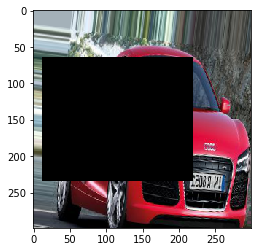

In [317]:
a,b = next(train_gen)
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(a[0].astype('int'))

In [134]:
def get_model(app, image_size, opt, num_class=196, lr=0.0001):
    if app=='Xception':
        application = Xception
    elif app=='VGG16':
        application = VGG16
    elif app=='ResNet50':
        application = ResNet50
    elif app=='InceptionV3':
        application = InceptionV3
    base_model = application(weights='imagenet', input_shape=(image_size,image_size,3), include_top=False)
    #base_model.trainable = False
    

    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='sigmoid'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(num_class, activation='softmax'))
    #model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

    return model

In [43]:
def get_model_path(model_dir, model_name, model_type):
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    from datetime import datetime
    now = datetime.now()
    date_time = now.strftime("%m%d_%H%M")
    model_path =model_dir +  "{}_{}_{}.{}".format(model_name , date_time ,model_type, '.hdf5')
    print('>>model path to save: {}'.format(model_path))
    return model_path

In [44]:
model_type='Xception'
image_size = 299 if model_type=='Xception' else 224
histories=[]
patient = 3
lr = 0.0001
epoch=300

In [45]:
model_name = 'baseline_randbox'
model_dir = '../model/'
model_path = get_model_path(model_dir, model_name, model_type)
model = get_model(app=model_type, image_size=image_size, opt=optimizers.RMSprop(lr=lr), lr=lr)
print('>>get model completed')

>>model path to save: ../model/baseline_randbox_0706_2104_Xception..hdf5
>>get model completed


In [46]:
def get_callback(patient, model_path, lr, total_count):
    callbacks = [
        EarlyStopping(monitor='val_loss',
                      patience=patient,
                      mode='min',
                      verbose=1),
        #ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = patient / 2, min_lr=0.00001, verbose=1, mode='min'),
        ModelCheckpoint(filepath=model_path,
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True,
                        mode='min'),
        ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.5, patience = patient / 2,
                          min_lr=0.00001, verbose=1, mode='min'),

    ]
    return callbacks

In [47]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size
    

In [48]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=get_steps(nb_train_sample, batch_size),
    epochs=epoch,
    validation_data=validation_gen,
    validation_steps=get_steps(nb_validation_sample, valid_batch_size),
    verbose=1,
    callbacks=get_callback(patient, model_path, lr, len(X_train))
)

Epoch 1/300
439/439 [==============================] - 188s 427ms/step - loss: 5.0687 - acc: 0.0323 - val_loss: 4.3227 - val_acc: 0.1637

Epoch 00001: val_loss improved from inf to 4.32273, saving model to ../model/baseline_randbox_0706_2104_Xception..hdf5
Epoch 2/300
439/439 [==============================] - 181s 412ms/step - loss: 4.0139 - acc: 0.1810 - val_loss: 3.1976 - val_acc: 0.3870

Epoch 00002: val_loss improved from 4.32273 to 3.19765, saving model to ../model/baseline_randbox_0706_2104_Xception..hdf5
Epoch 3/300
439/439 [==============================] - 181s 413ms/step - loss: 2.9631 - acc: 0.3943 - val_loss: 2.2086 - val_acc: 0.6050

Epoch 00003: val_loss improved from 3.19765 to 2.20863, saving model to ../model/baseline_randbox_0706_2104_Xception..hdf5
Epoch 4/300
439/439 [==============================] - 181s 413ms/step - loss: 2.0272 - acc: 0.6122 - val_loss: 1.4399 - val_acc: 0.7285

Epoch 00004: val_loss improved from 2.20863 to 1.43993, saving model to ../model/ba

use 5000 images
baseline + ratio image test
